<table>
    <tr>
        <td>
            <img src="https://arm.gov/uploads/TRACER_skyline.jpg" style="height: 200px;" alt="TRACER Campaign"></img>
        </td>
        <td>
            <h1>Atmospheric Radiation Measurement user facility (ARM)</h1>
            <h1>TRacking Aerosol Convection interations ExpeRiment (TRACER)</h1>
            <h2>July 16-19, 2022 Dust Event</h2>
            Notebook for data exploration of ARM aerosol and lidar data. </br>
            Corresponding Author: Adam Theisen (atheisen@anl.gov)
        </td>
    </tr>
</table>

## Overview
The first notebook in this series was an introduction to some of the features in ACT.  In this notebook, we will be exploring different types of data and bringing it all together to get a view of this dust event.

1. Micropulse Lidar (MPL) Data
1. Aerodynamic Particle Sizer (APS) Data
1. Putting it All Together
1. Questions for the User to Explore

## Prerequisites
This notebook will rely heavily on Python and the [Atmospheric data Community Toolkit (ACT)](https://github.com/ARM-DOE/ACT).  Don't worry if you don't have experience with either, this notebook will walk you though what you need to know.

You will also need an account and token to download data using the ARM Live webservice.  Navigate to the [webservice information page](https://adc.arm.gov/armlive/) and log in to get your token.  Your account username will be your ARM username.

| Concepts | Importance | Notes |
| --- | --- | --- |
| [ACT](https://github.com/ARM-DOE/ACT) | Helpful | |
| 3-ACT-Basics.ipynb | Helpful ||

- **Time to learn**: 60 Minutes
- **System requirements**:
    - Python 3.11 or latest
    - ACT v2.0.0 or latest
    - numpy
    - xarray
    - matplotlib

---

## Imports
Let's get started with some data!  But first, we need to import some libraries.

In [30]:
import act
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import glob

import seaborn as sns
sns.set_style('ticks')
%config InlineBackend.figure_format='retina'

## Micropulse Lidar (MPL) Data
ARM has many value-added products (VAPs) that apply corrections, additional quality control, retrievals, and more.  These are a great way to get the data if you don't want to do the added processing yourself.  In this case, there is a VAP for the MPL with the datastream hou30smplcmask1zwangM1.c1 that you could utilize.  For this case though, let's download the instrument data and correct it ourselves using ACT.

In [32]:
# Set your username and token here!
username = 'jyyoon'
token = '34cb1c19d27236d3'

# Set the datastream and start/enddates
datastream = 'houmplpolfsM1.b1'
startdate = '2022-07-16'
enddate = '2022-07-16'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

[DOWNLOADING] houmplpolfsM1.b1.20220716.000007.nc

If you use these data to prepare a publication, please cite:

Muradyan, P., Cromwell, E., Koontz, A., Coulter, R., Flynn, C., Ermold, B., &
OBrien, J. Micropulse Lidar (MPLPOLFS). Atmospheric Radiation Measurement (ARM)
User Facility. https://doi.org/10.5439/1320657



In [33]:
# Let's read in the data using ACT and check out the data
ds_mpl = act.io.read_arm_netcdf(result)

# Now we can correct the data
ds_mpl = act.corrections.correct_mpl(ds_mpl)

In [34]:
# Let's plot up the data to see what it looks like. But first,
# if you look at the variables, you would see the the variable
# we're going to plot has range_bins as it's 2nd dimension.
# We want it to be height so we have to swap some coordinates around
ds_mpl.coords['height'] = ds_mpl.height
ds_mpl = ds_mpl.swap_dims({'range_bins': 'height'})

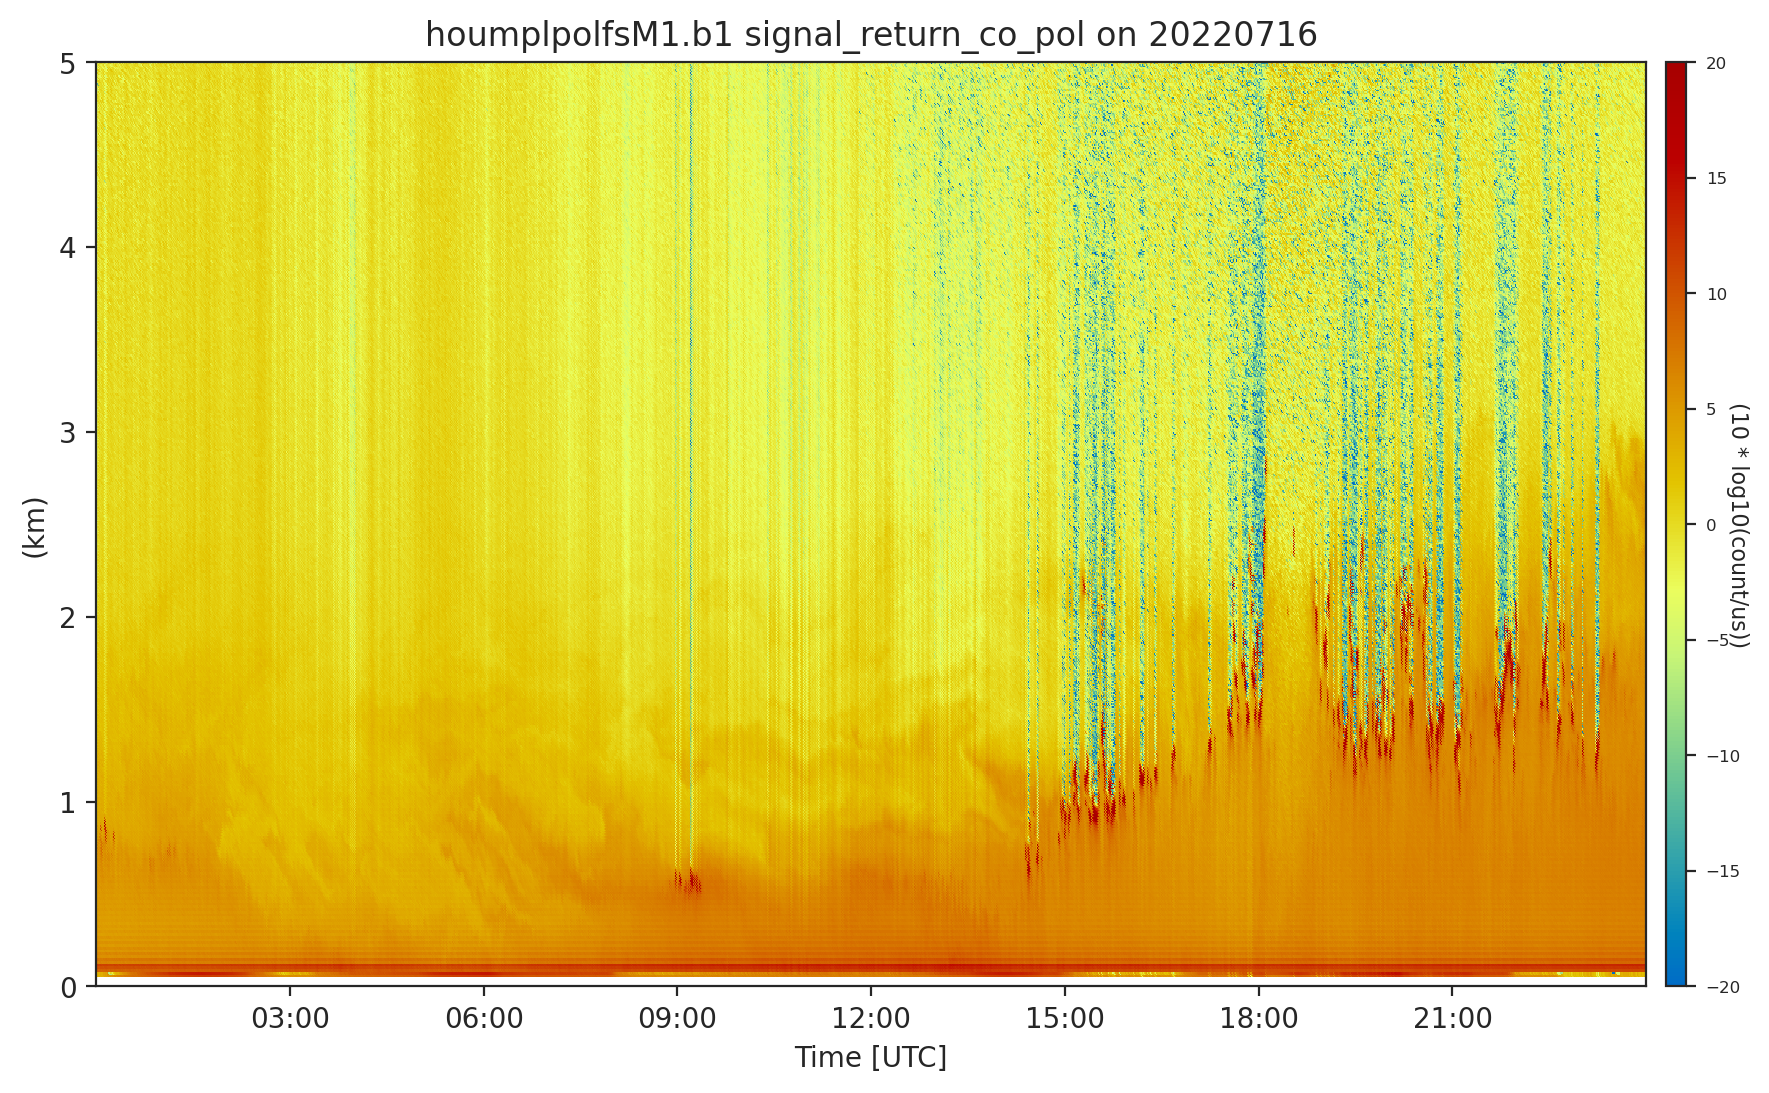

In [35]:
# It's a lot of data, so it will take some time!
display = act.plotting.TimeSeriesDisplay(ds_mpl, figsize=(10, 6))
display.plot('signal_return_co_pol', cvd_friendly=True, vmin=-20, vmax=20)

# This instrument collects data over 30 km so let's constrain
# this to just the lower 5 km
display.set_yrng([0, 5])
plt.show()

### Polarized Lidar
The micropulse lidar is a polarized lidar which means that it can be used to inform us about the shape of the particles that the light is interacting with.  This website from the [Leibniz Institute for Troposheric Research](https://www.tropos.de/en/research/projects-infrastructures-technology/technology-at-tropos/remote-sensing/polarization-lidar) has a nice explanation of polarized lidar.

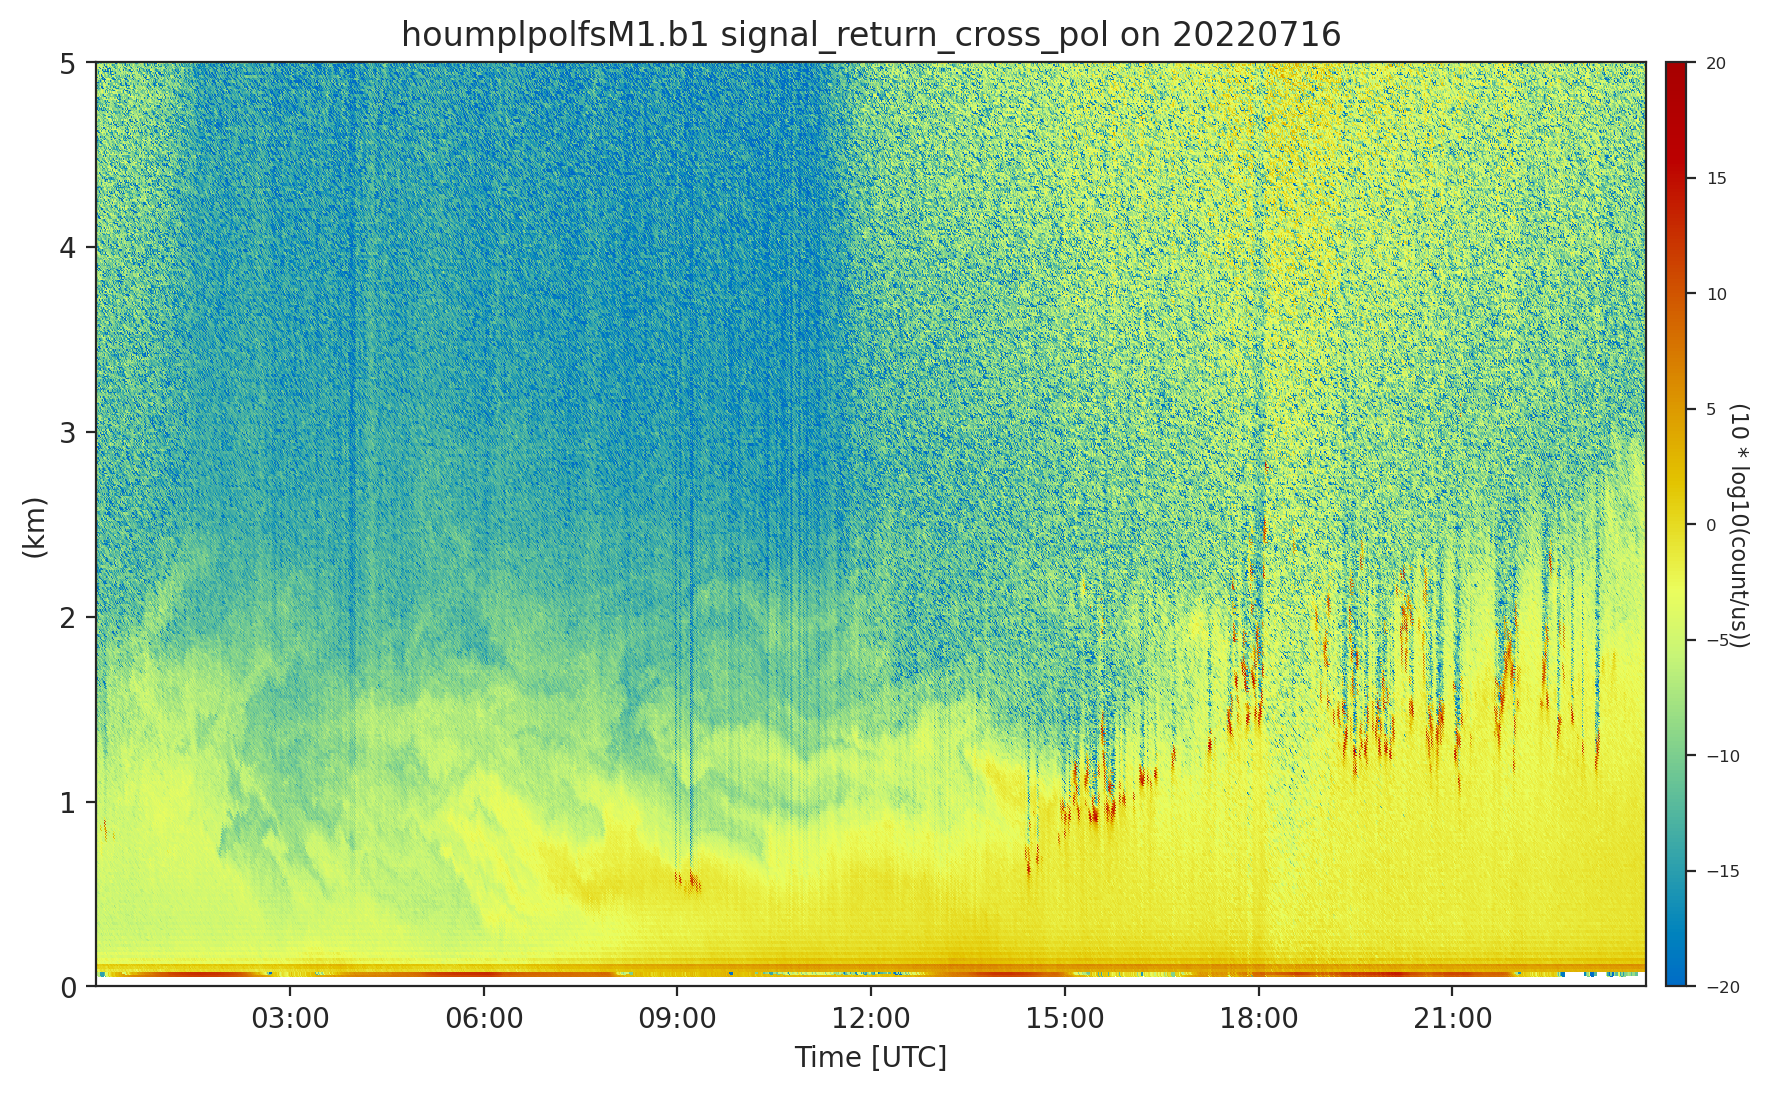

In [36]:
# Let's look at the cross polarization to get some more information
# It's a lot of data, so it will take some time!
display = act.plotting.TimeSeriesDisplay(ds_mpl, figsize=(10, 6))
display.plot('signal_return_cross_pol', cvd_friendly=True, vmin=-20, vmax=20)

# This instrument collects data over 30 km so let's constrain
# this to just the lower 5 km
display.set_yrng([0, 5])
plt.show()

## Aerosol Particle Size Data
Dust particles are generally under 10 µm or 10,000 nm and ARM has a variety of instruments that measure across different ranges. The chart below shows the ranges for each instrument and where we can expect to see the dust particles.

<img src="./images/aerosol_sizing.png" width=900>

In [39]:
# Download the data as before
datastream = 'houaosapsM1.b1'
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

# and read it in
ds_aps = act.io.arm.read_arm_netcdf(result)

[DOWNLOADING] houaosapsM1.b1.20220716.000000.nc

If you use these data to prepare a publication, please cite:

Singh, A., Oliveira, D., Koontz, A., Sedlacek, A., & Kuang, C. Aerodynamic
Particle Sizer (AOSAPS). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1407135



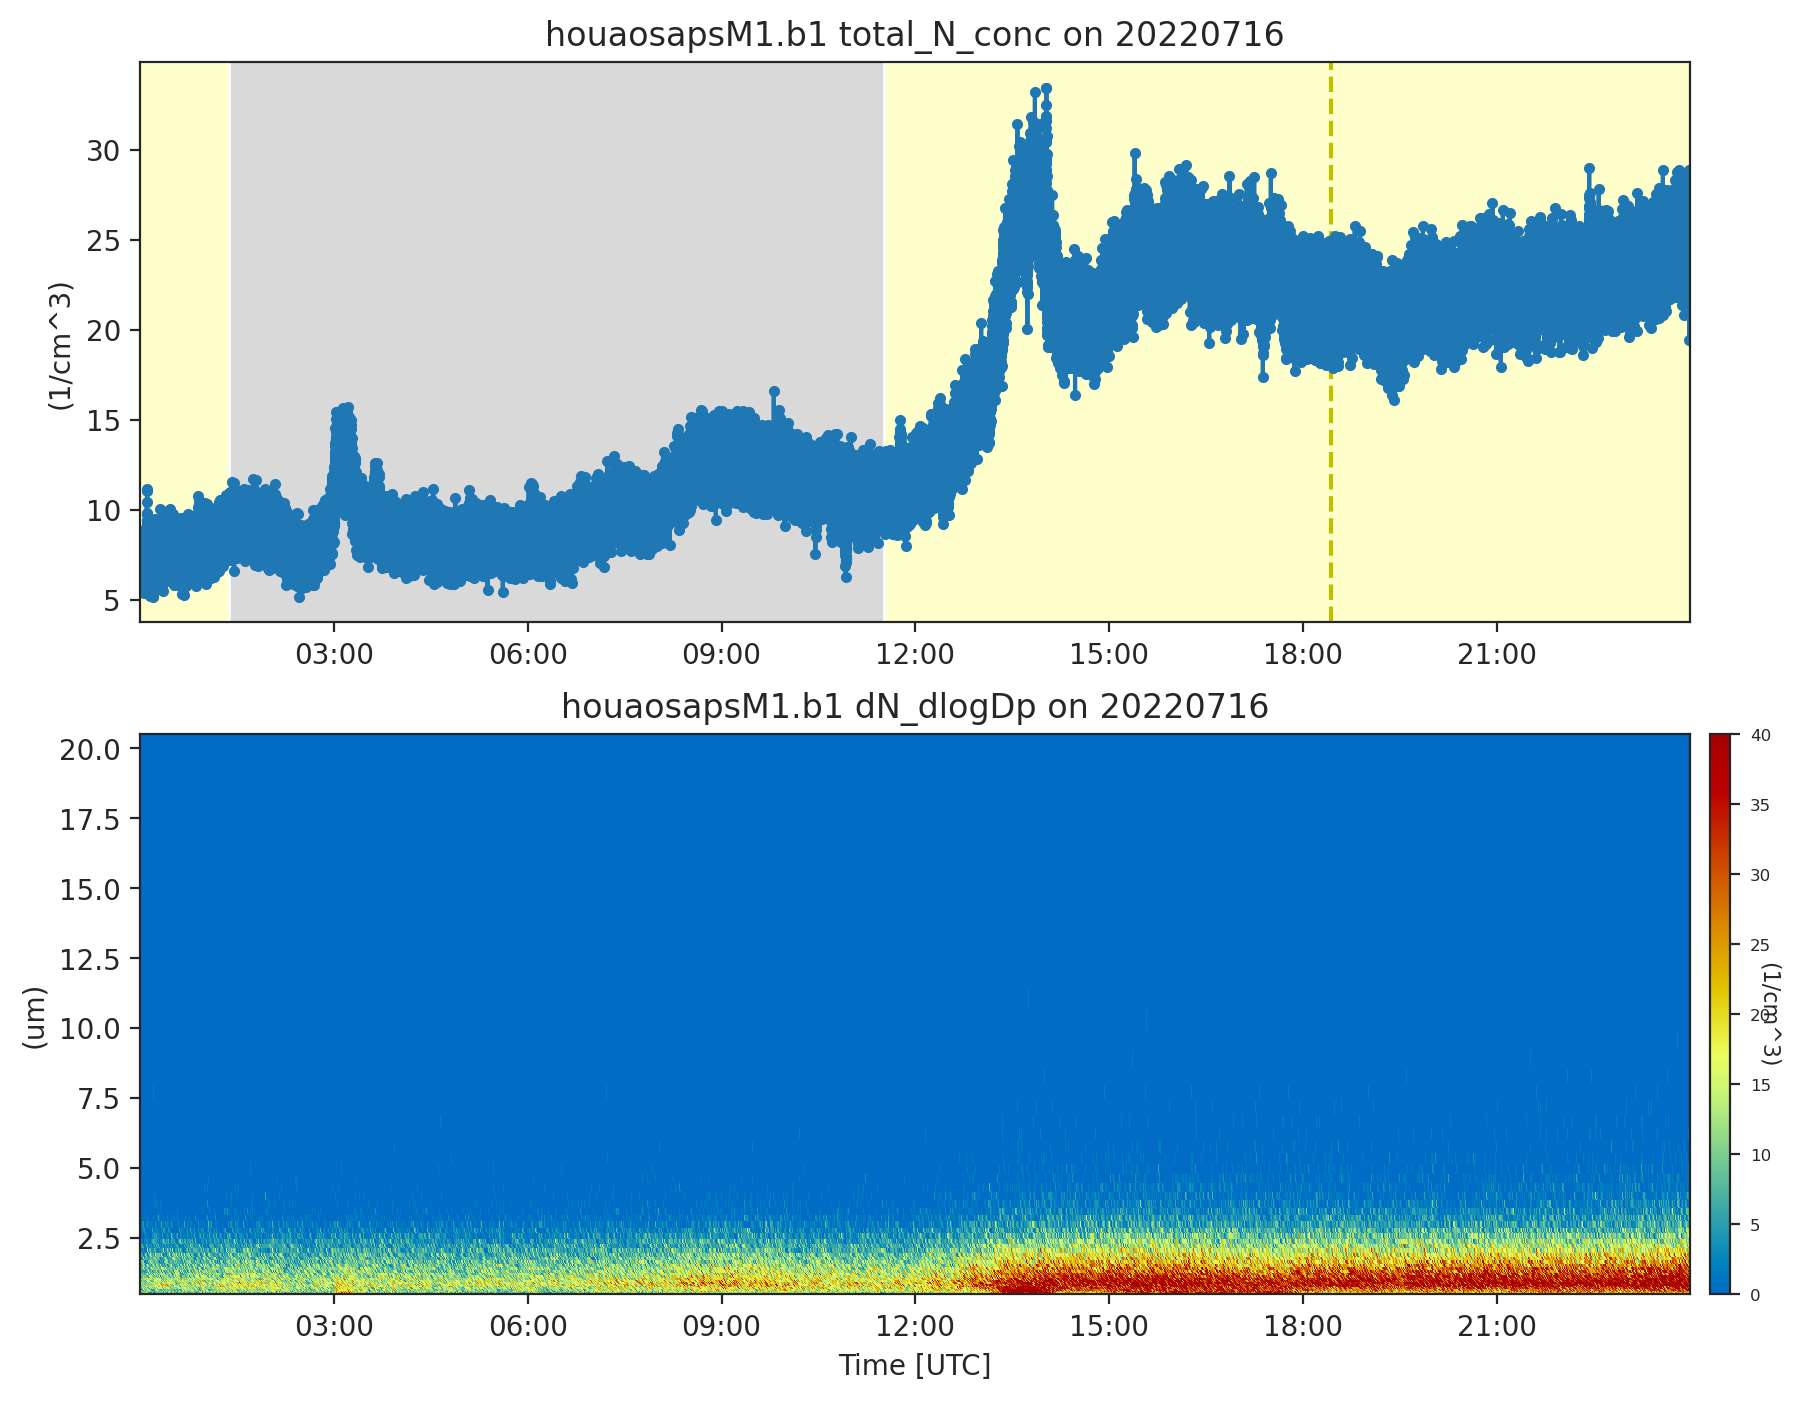

In [40]:
# Let's plot up the size distribution and number concentration
# These data are taken every second so it will take a little bit
display = act.plotting.TimeSeriesDisplay(ds_aps, subplot_shape=(2,), figsize=(10,8))
display.plot('total_N_conc', subplot_index=(0,))
display.day_night_background(subplot_index=(0,))
display.plot('dN_dlogDp', subplot_index=(1,), vmax=40, cvd_friendly=True)

plt.show()

## Putting it All Together
Let's start pulling these data together into the same plots so we can see what's going on.

In [41]:
# Let's start fresh and get all the data and maybe expand the dates
startdate = '2022-07-10'
enddate = '2022-07-20'

# MPL - Let's try the VAP this time
datastream = 'hou30smplcmask1zwangM1.c1'
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
ds_mpl = act.io.arm.read_arm_netcdf(result)

# APS
datastream = 'houaosapsM1.b1'
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
ds_aps = act.io.arm.read_arm_netcdf(result)

# SMPS
datastream = 'houaossmpsM1.b1'
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
ds_smps = act.io.arm.read_arm_netcdf(result)

#ACSM
datastream = 'houaosacsmM1.b2'
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
ds_acsm = act.io.arm.read_arm_netcdf(result)

#PSAP
datastream = 'houaospsap3w1mM1.b1'
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
ds_psap = act.io.arm.read_arm_netcdf(result)

#SP2
datastream = 'houaossp2bc60sM1.b1'
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
ds_sp2 = act.io.arm.read_arm_netcdf(result)

# MET
datastream = 'houmetM1.b1'
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
ds_met = act.io.arm.read_arm_netcdf(result)

[DOWNLOADING] hou30smplcmask1zwangM1.c1.20220719.000001.nc
[DOWNLOADING] hou30smplcmask1zwangM1.c1.20220717.000008.nc
[DOWNLOADING] hou30smplcmask1zwangM1.c1.20220712.000002.nc
[DOWNLOADING] hou30smplcmask1zwangM1.c1.20220714.000004.nc
[DOWNLOADING] hou30smplcmask1zwangM1.c1.20220718.000000.nc
[DOWNLOADING] hou30smplcmask1zwangM1.c1.20220710.000008.nc
[DOWNLOADING] hou30smplcmask1zwangM1.c1.20220713.000003.nc
[DOWNLOADING] hou30smplcmask1zwangM1.c1.20220715.000006.nc
[DOWNLOADING] hou30smplcmask1zwangM1.c1.20220716.000007.nc
[DOWNLOADING] hou30smplcmask1zwangM1.c1.20220711.000000.nc

If you use these data to prepare a publication, please cite:

Sivaraman, C., Flynn, D., Riihimaki, L., Comstock, J., & Zhang, D. Cloud mask
from Micropulse Lidar (30SMPLCMASK1ZWANG). Atmospheric Radiation Measurement
(ARM) User Facility. https://doi.org/10.5439/1508389

[DOWNLOADING] houaosapsM1.b1.20220711.000000.nc
[DOWNLOADING] houaosapsM1.b1.20220718.000000.nc
[DOWNLOADING] houaosapsM1.b1.20220712.0000

In [42]:
# Before we proceed to plotting, let's reduce the MPL data down a little bit
# This will remove all data where heights are greater than 5
ds_mpl = ds_mpl.where(ds_mpl.height <= 5, drop=True)

# This will resample to 1 minute
ds_mpl = ds_mpl.resample(time='1min').nearest()

In [44]:
# Let's not forget about QCing the data!
# We can remove all the bad data from each aerosol dataset
ds_aps.clean.cleanup()
# ds_aps = act.qc.arm.add_dqr_to_qc(ds_aps)
ds_aps.qcfilter.datafilter(rm_assessments=['Bad'], del_qc_var=False)

ds_smps.clean.cleanup()
# ds_smps = act.qc.arm.add_dqr_to_qc(ds_smps)
ds_smps.qcfilter.datafilter(rm_assessments=['Bad'], del_qc_var=False)

ds_acsm.clean.cleanup()
# ds_acsm = act.qc.arm.add_dqr_to_qc(ds_acsm)
ds_acsm.qcfilter.datafilter(rm_assessments=['Bad'], del_qc_var=False)

ds_sp2.clean.cleanup()
# ds_sp2 = act.qc.arm.add_dqr_to_qc(ds_sp2)
ds_sp2.qcfilter.datafilter(rm_assessments=['Bad'], del_qc_var=False)

ds_psap.clean.cleanup()
# ds_psap = act.qc.arm.add_dqr_to_qc(ds_psap)
ds_psap.qcfilter.datafilter(rm_assessments=['Bad'], del_qc_var=False)

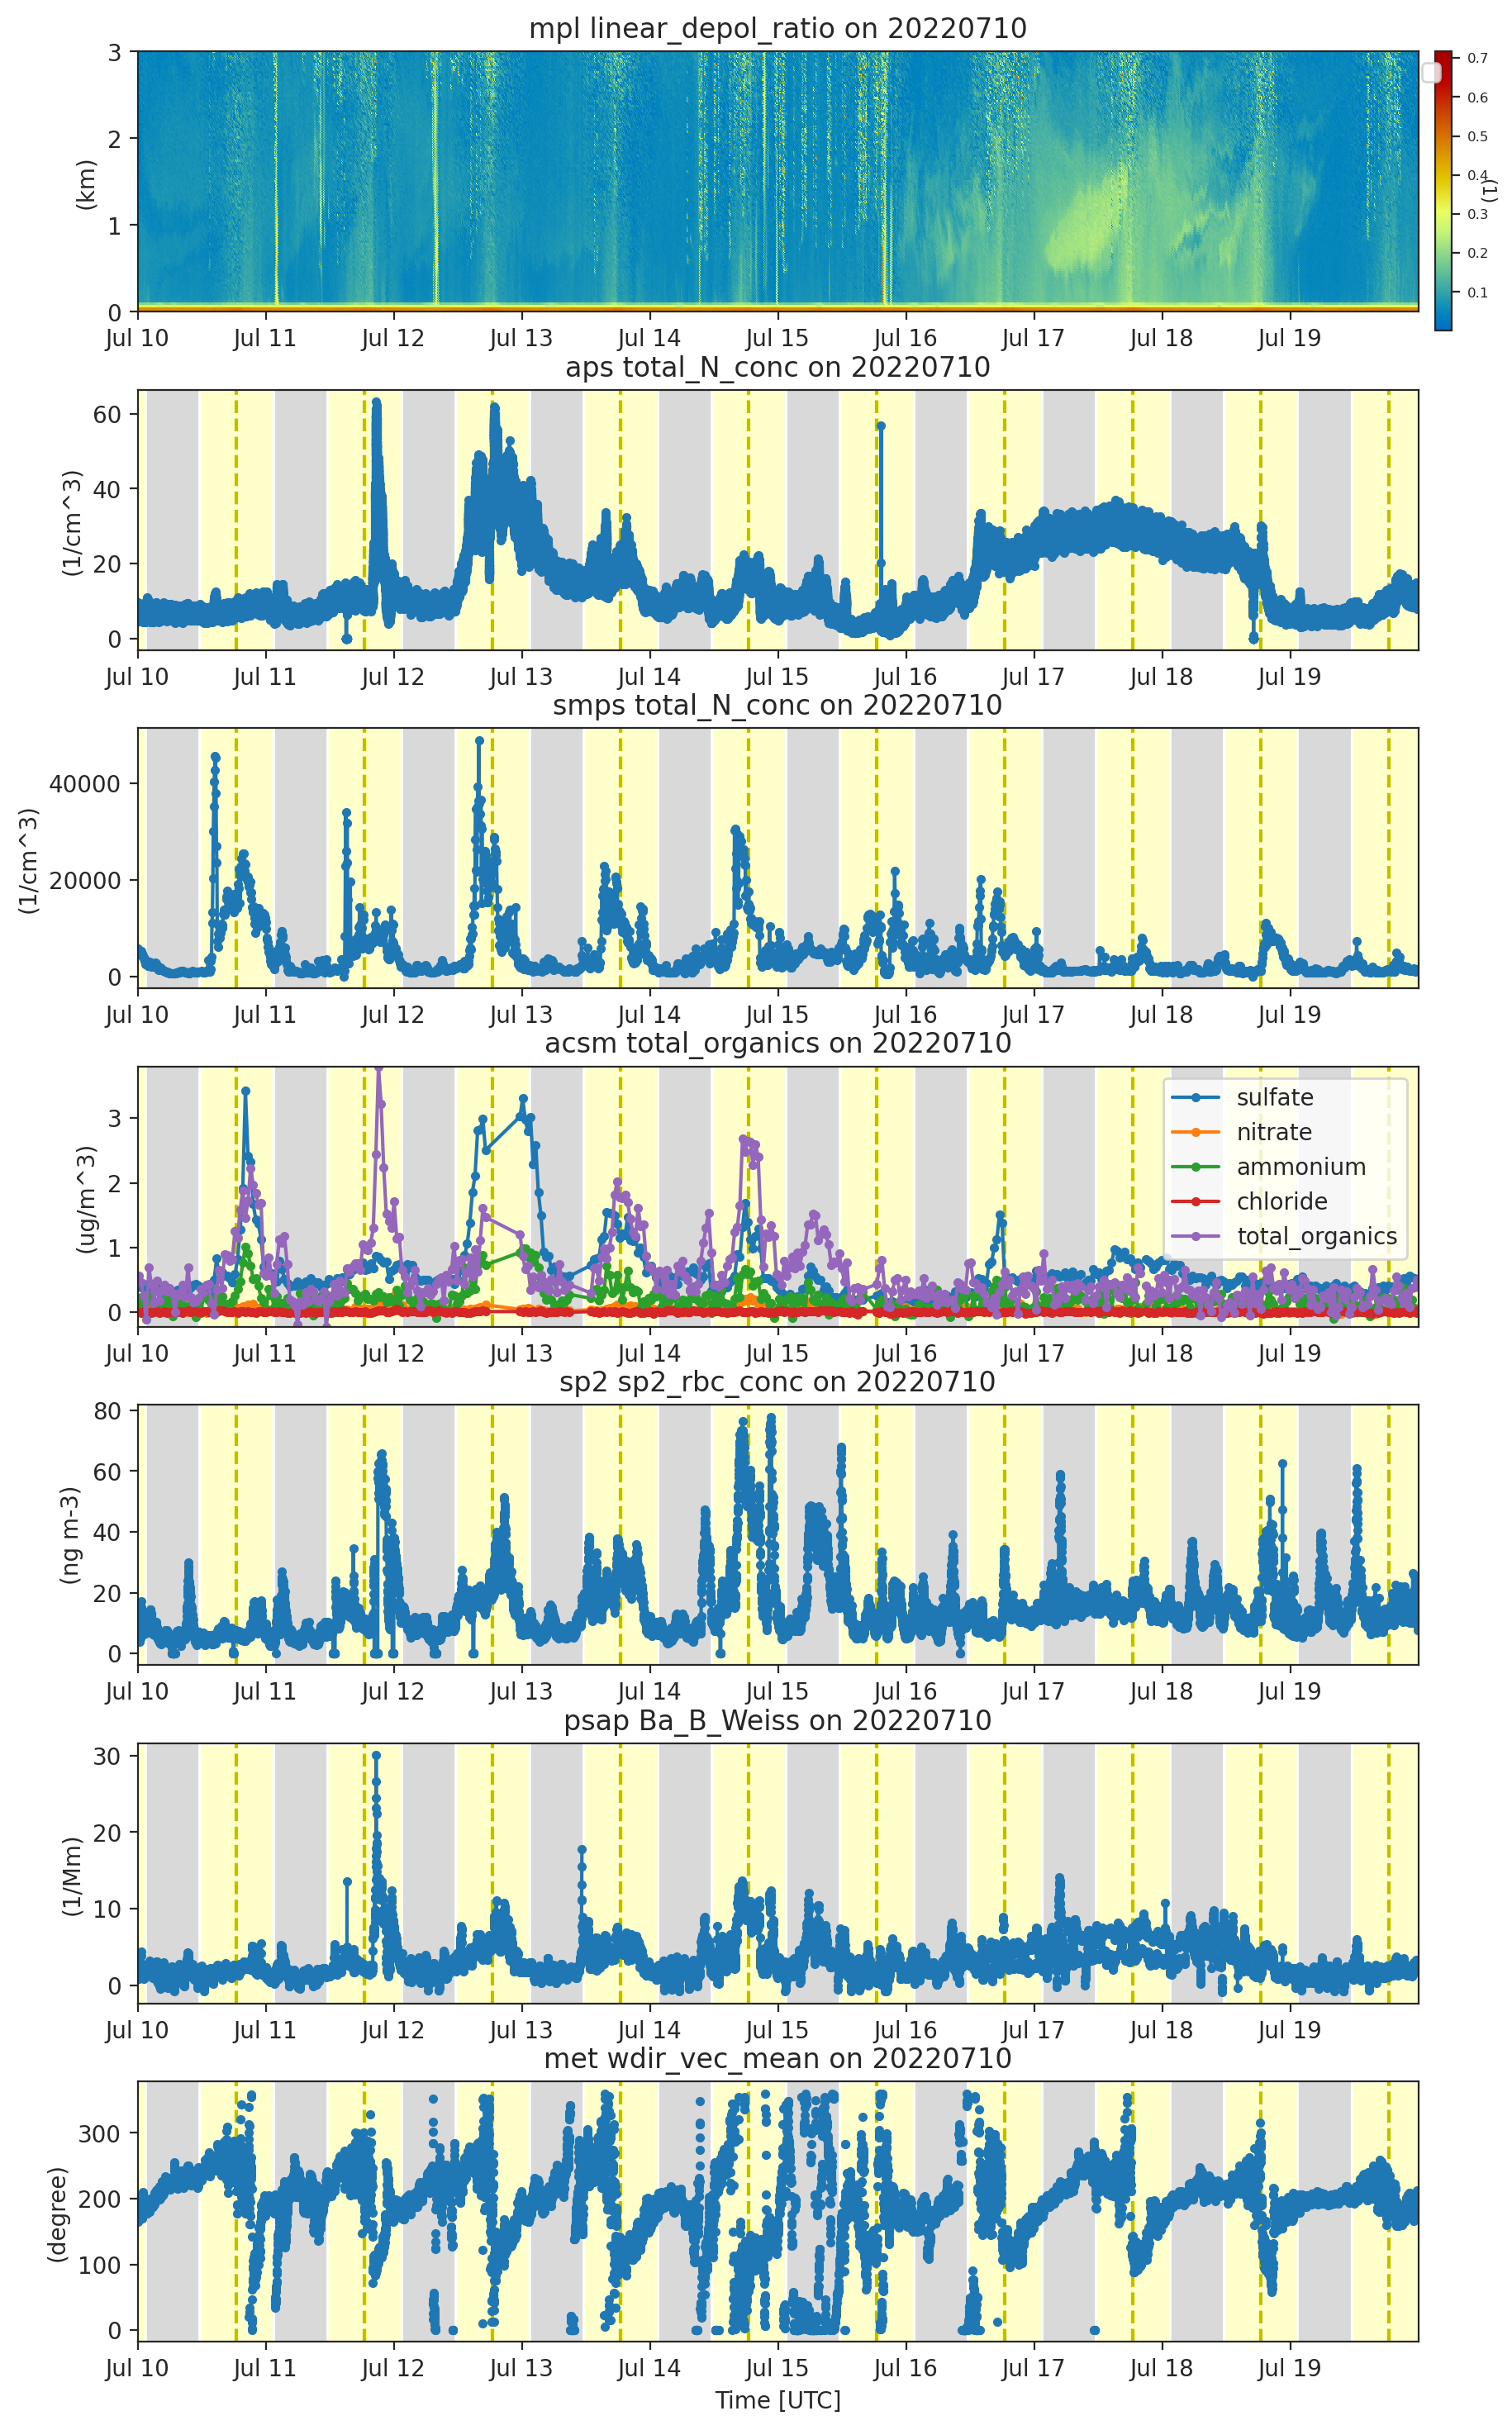

In [45]:
# We can pass a dictionary to the display objects with multiple datasets
# So let's plot all this up!
display = act.plotting.TimeSeriesDisplay({'aps': ds_aps, 'mpl': ds_mpl, 'smps': ds_smps, 'acsm': ds_acsm, 'psap': ds_psap, 'sp2': ds_sp2, 'met': ds_met},
                                         subplot_shape=(7,), figsize=(10,18))

# MPL Plot
# Variable names of interest linear_depol_ratio, linear_depol_snr, backscatter_snr
display.plot('linear_depol_ratio', dsname='mpl', subplot_index=(0,), cvd_friendly=True)
display.set_yrng([0, 3], subplot_index=(0,))

# APS Plot
display.plot('total_N_conc', dsname='aps', subplot_index=(1,))
display.day_night_background(dsname='aps', subplot_index=(1,))

# SMPS Plot
display.plot('total_N_conc', dsname='smps', subplot_index=(2,))
display.day_night_background(dsname='smps', subplot_index=(2,))

# ACSM plot
display.plot('sulfate', dsname='acsm', subplot_index=(3,), label='sulfate')
display.plot('nitrate', dsname='acsm', subplot_index=(3,), label='nitrate')
display.plot('ammonium', dsname='acsm', subplot_index=(3,), label='ammonium')
display.plot('chloride', dsname='acsm', subplot_index=(3,), label='chloride')
display.plot('total_organics', dsname='acsm', subplot_index=(3,), label='total_organics')

display.day_night_background(dsname='acsm', subplot_index=(3,))

# SP2 Plot
display.plot('sp2_rbc_conc', dsname='sp2', subplot_index=(4,))
display.day_night_background(dsname='sp2', subplot_index=(4,))

# PSAP Plot
display.plot('Ba_B_Weiss', dsname='psap', subplot_index=(5,))
display.day_night_background(dsname='psap', subplot_index=(5,))

# MET Wind Plot
display.plot('wdir_vec_mean', dsname='met', subplot_index=(6,), linestyle='', marker='.')
#display.plot('wspd_vec_mean', dsname='met', subplot_index=(6,), marker=None, secondary_y=True, color='orange', label='Wind Speed')
display.day_night_background(dsname='met', subplot_index=(6,))

plt.subplots_adjust(hspace=0.3)
plt.legend()
plt.savefig('./images/output.png')
plt.show()

#### Check this out
[Floutsi et al 2023](https://amt.copernicus.org/articles/16/2353/2023/) has a great paper that shows how different aerosols can have different ratios.  In [Figure 3](https://amt.copernicus.org/articles/16/2353/2023/amt-16-2353-2023-f03-web.png), you can see that Sharan dust has a slightly different signal than Central Asian dust.

### Try more data!

Go back and adjust the start/end date around this period and see how things change!  You can also try adding in some of the other instruments like the OPC (houaosopcM1.b1: calc_dust_weight or total_N_conc) or the NEPHDRY (houaosnephdry1mM1.b1: Bs_B_Dry_Neph3W).  You can find a full list of data products on the ARM TRACER [website](https://www.arm.gov/research/campaigns/amf2021tracer#:~:text=Order%20Data-,HOU%20DATA%20SOURCES,-NAME)

## Advanced Visualizations and Processing
Let's try and dive into the data a little more and see if there are any patterns in the data based on the direction of the wind.

### Data Roses

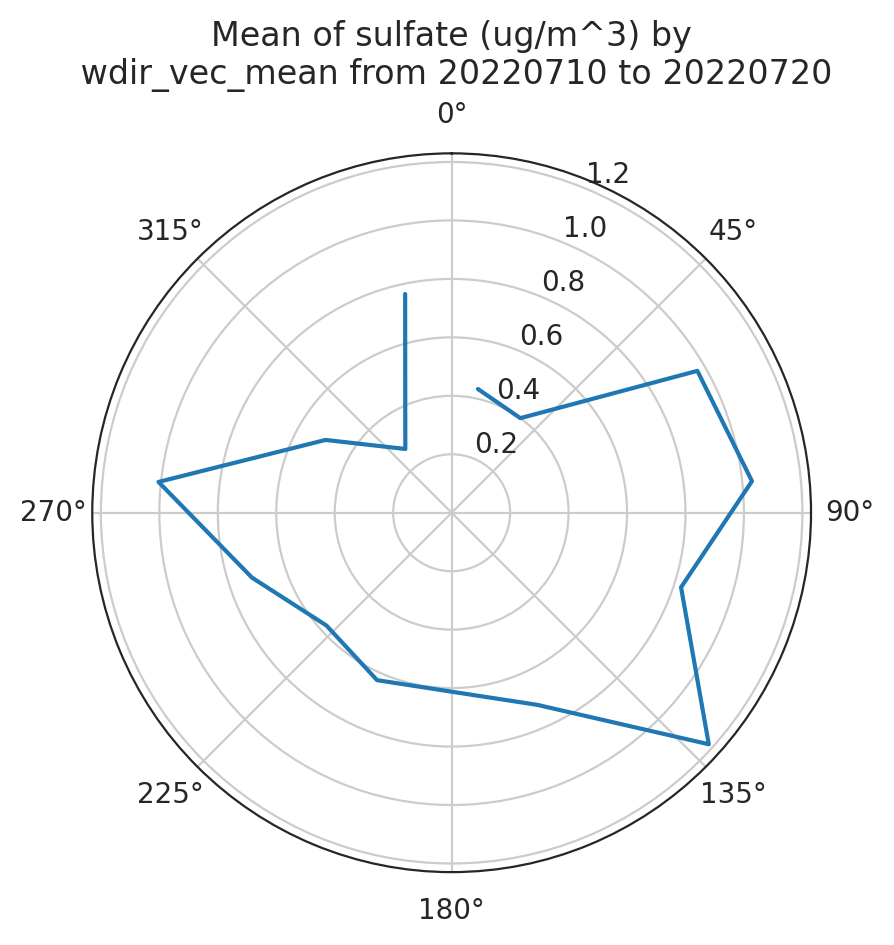

In [46]:
# We already should have the data loaded up so let's explore with some data roses
# First we need to combine data and to do that, we need to get it on the same time grid
ds_combined = xr.merge([ds_met.resample(time='30min').nearest(), ds_acsm.resample(time='30min').nearest()], compat='override')

# Plot out the data rose using the WindRose display object
display = act.plotting.WindRoseDisplay(ds_combined)
display.plot_data('wdir_vec_mean', 'wspd_vec_mean', 'sulfate', num_dirs=15, plot_type='line', line_plot_calc='mean')
plt.show()

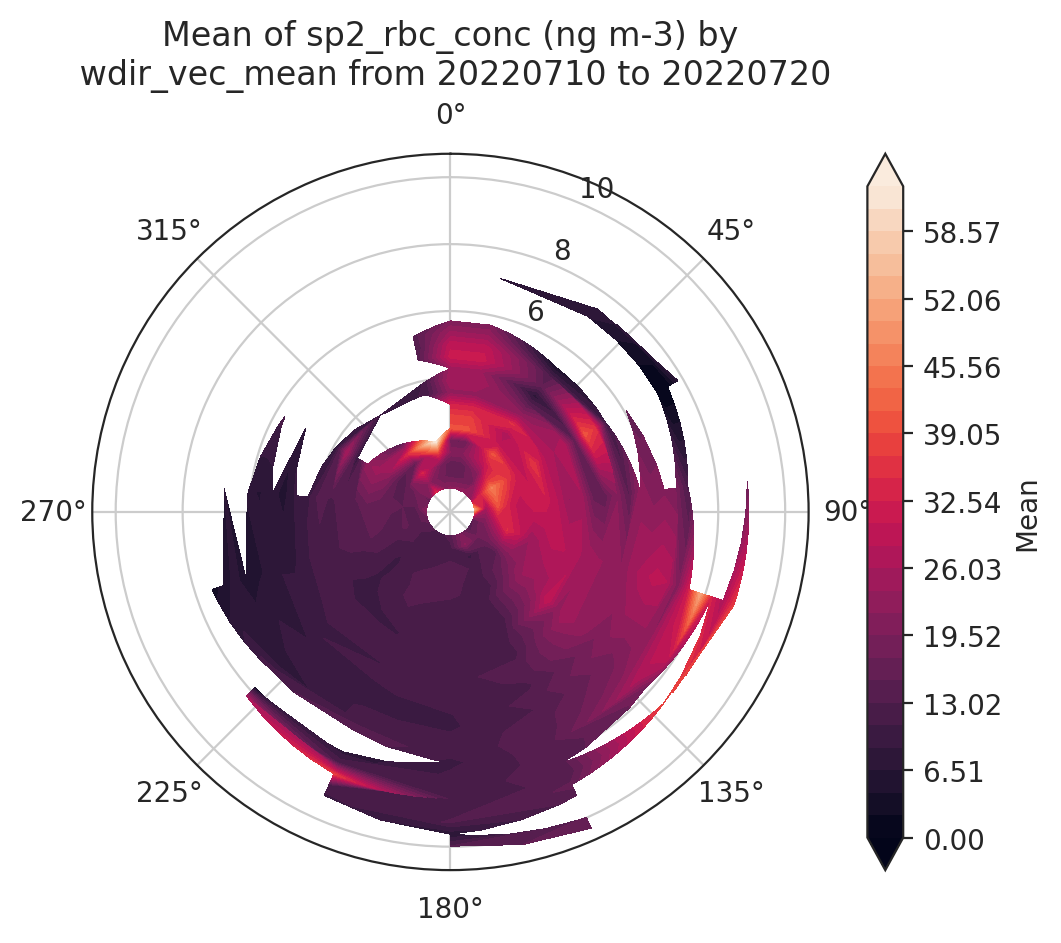

In [47]:
# First we need to combine data and to do that, we need to get it on the same time grid
ds_combined = xr.merge([ds_met.resample(time='1min').nearest(), ds_sp2.resample(time='1min').nearest()], compat='override')

# Plot out the data rose using the WindRose display object
display = act.plotting.WindRoseDisplay(ds_combined)
# Let's try a different type of data rose that will show the mean Black Carbon Concentration
# depending on wind direction and speed
display.plot_data('wdir_vec_mean', 'wspd_vec_mean', 'sp2_rbc_conc', num_dirs=15, plot_type='contour', contour_type='mean')
plt.show()

### Checkout the area
The AMF was deployed at [La Porte Municipal Airport](https://www.google.com/maps/place/Airport+Blvd/@29.6652378,-95.0466689,9165m/data=!3m1!1e3!4m7!3m6!1s0x863f6020e5e0ea21:0x792ee34f8eaac3e8!4b1!8m2!3d29.6663473!4d-95.0578571!16s%2Fg%2F1wbf_smp?entry=ttu).  Check out the google map and see if this mapes sense!

### Now back to the dust event!
Let's see if we can look at the lowest layers in the MPL data and see how they compare to the APS data.  For this, we can use simple matplotlib plots to investigate as well.

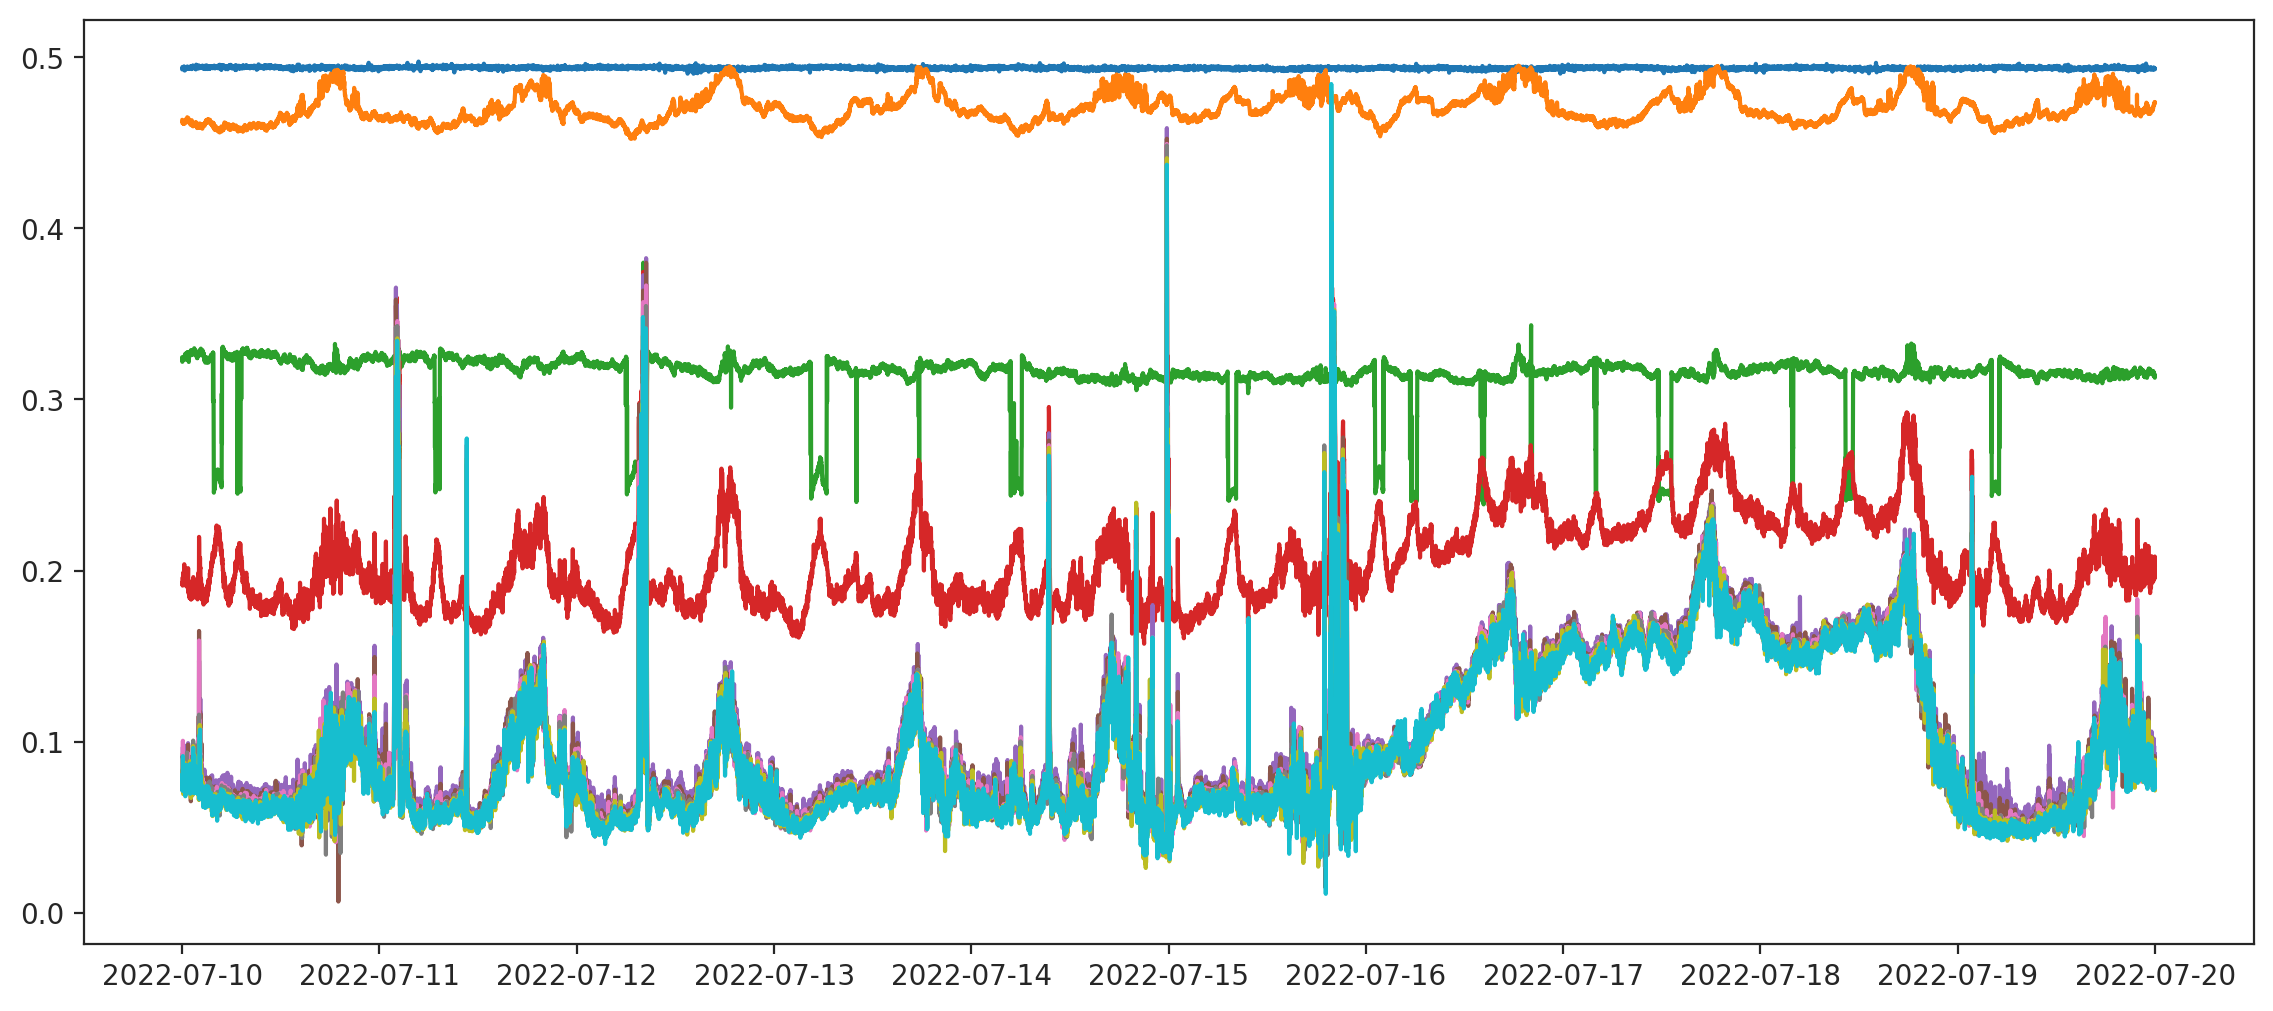

In [53]:
# Let's take a slice of the data to figure out where the signal
# may be showing up in the profile
data = ds_mpl['linear_depol_ratio'].values[:, 0:10]

fig, ax = plt.subplots(figsize=(14,6))
ax.plot(ds_mpl['time'], data)
plt.show()

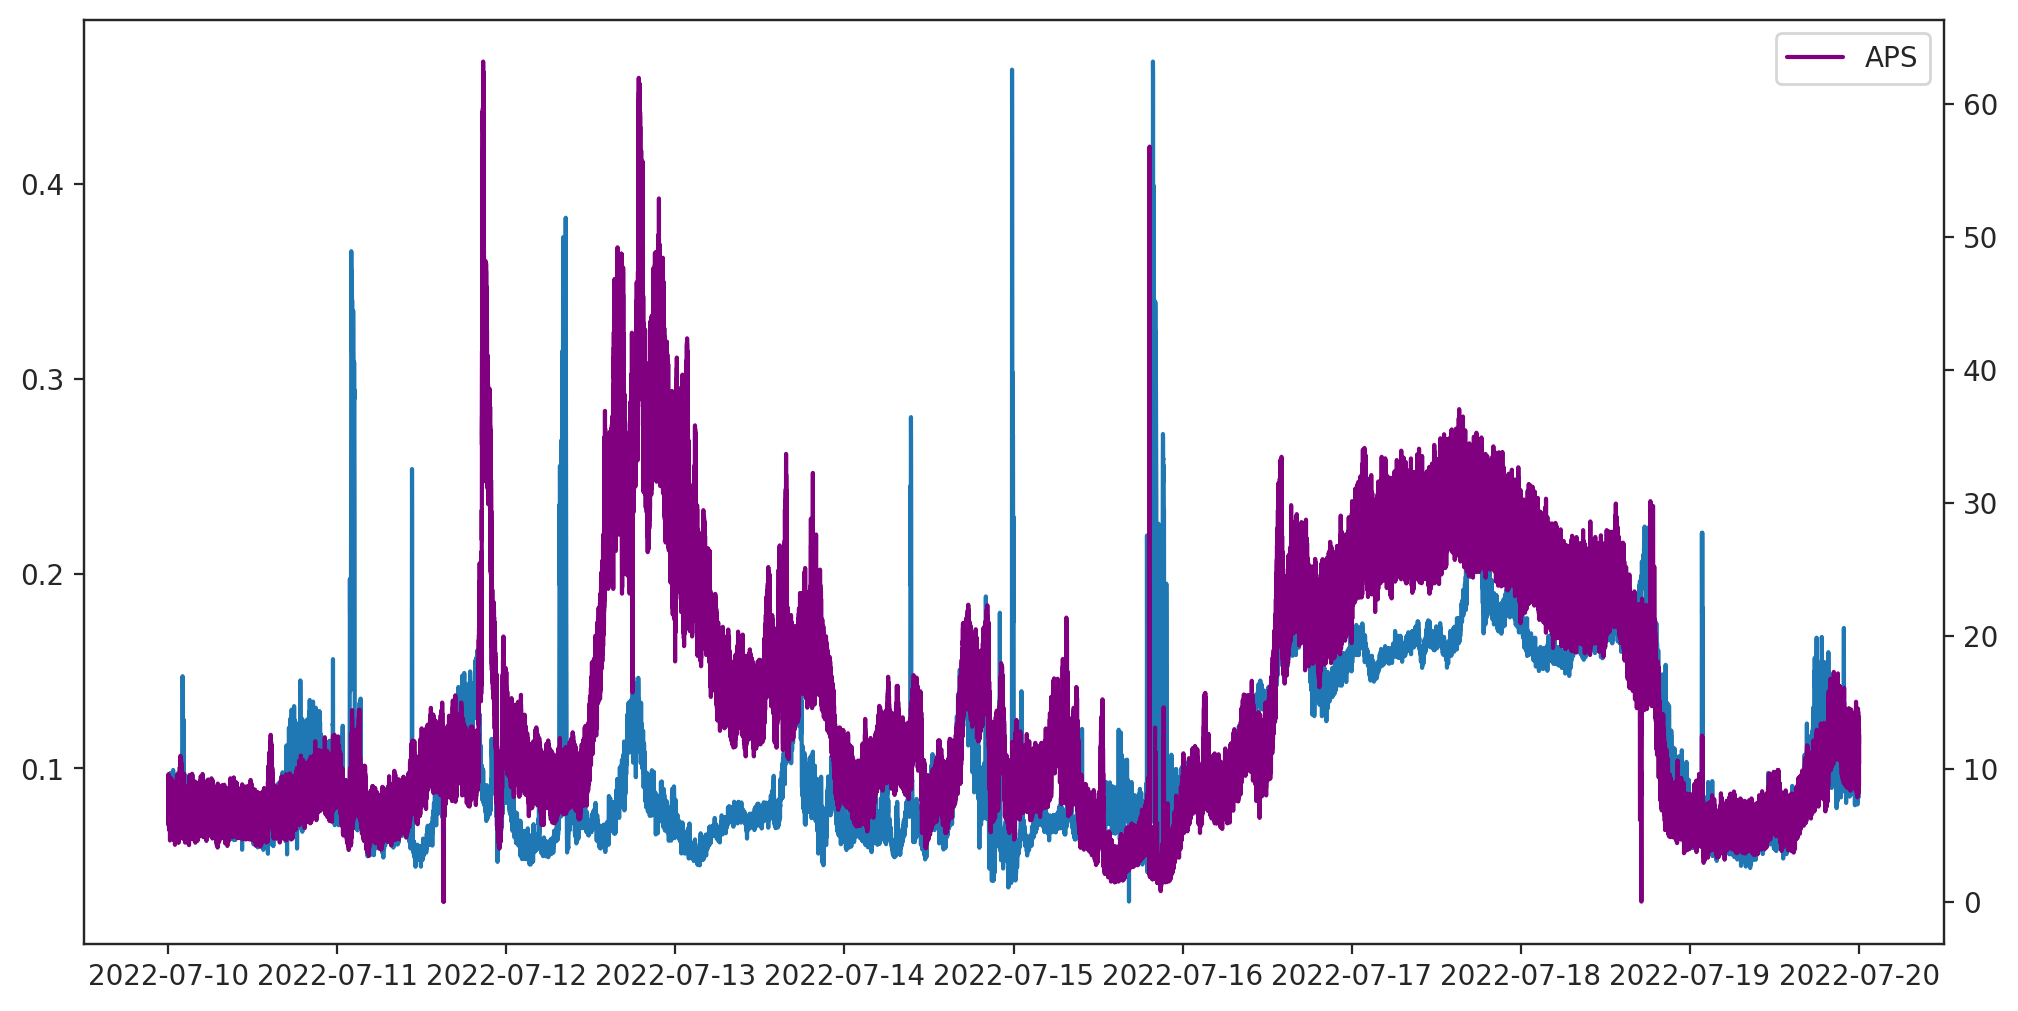

In [54]:
# Let's do it again and add in the APS data
# Other variables to try: backscatter_snr, linear_depol_snr, linear_depol_ratio
data = ds_mpl['linear_depol_ratio'].values[:, 4]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(ds_mpl['time'], data, label='MPL LDR')

ax2 = ax.twinx()
ax2.plot(ds_aps['time'], ds_aps['total_N_conc'], color='purple', label='APS')
plt.legend()
plt.show()

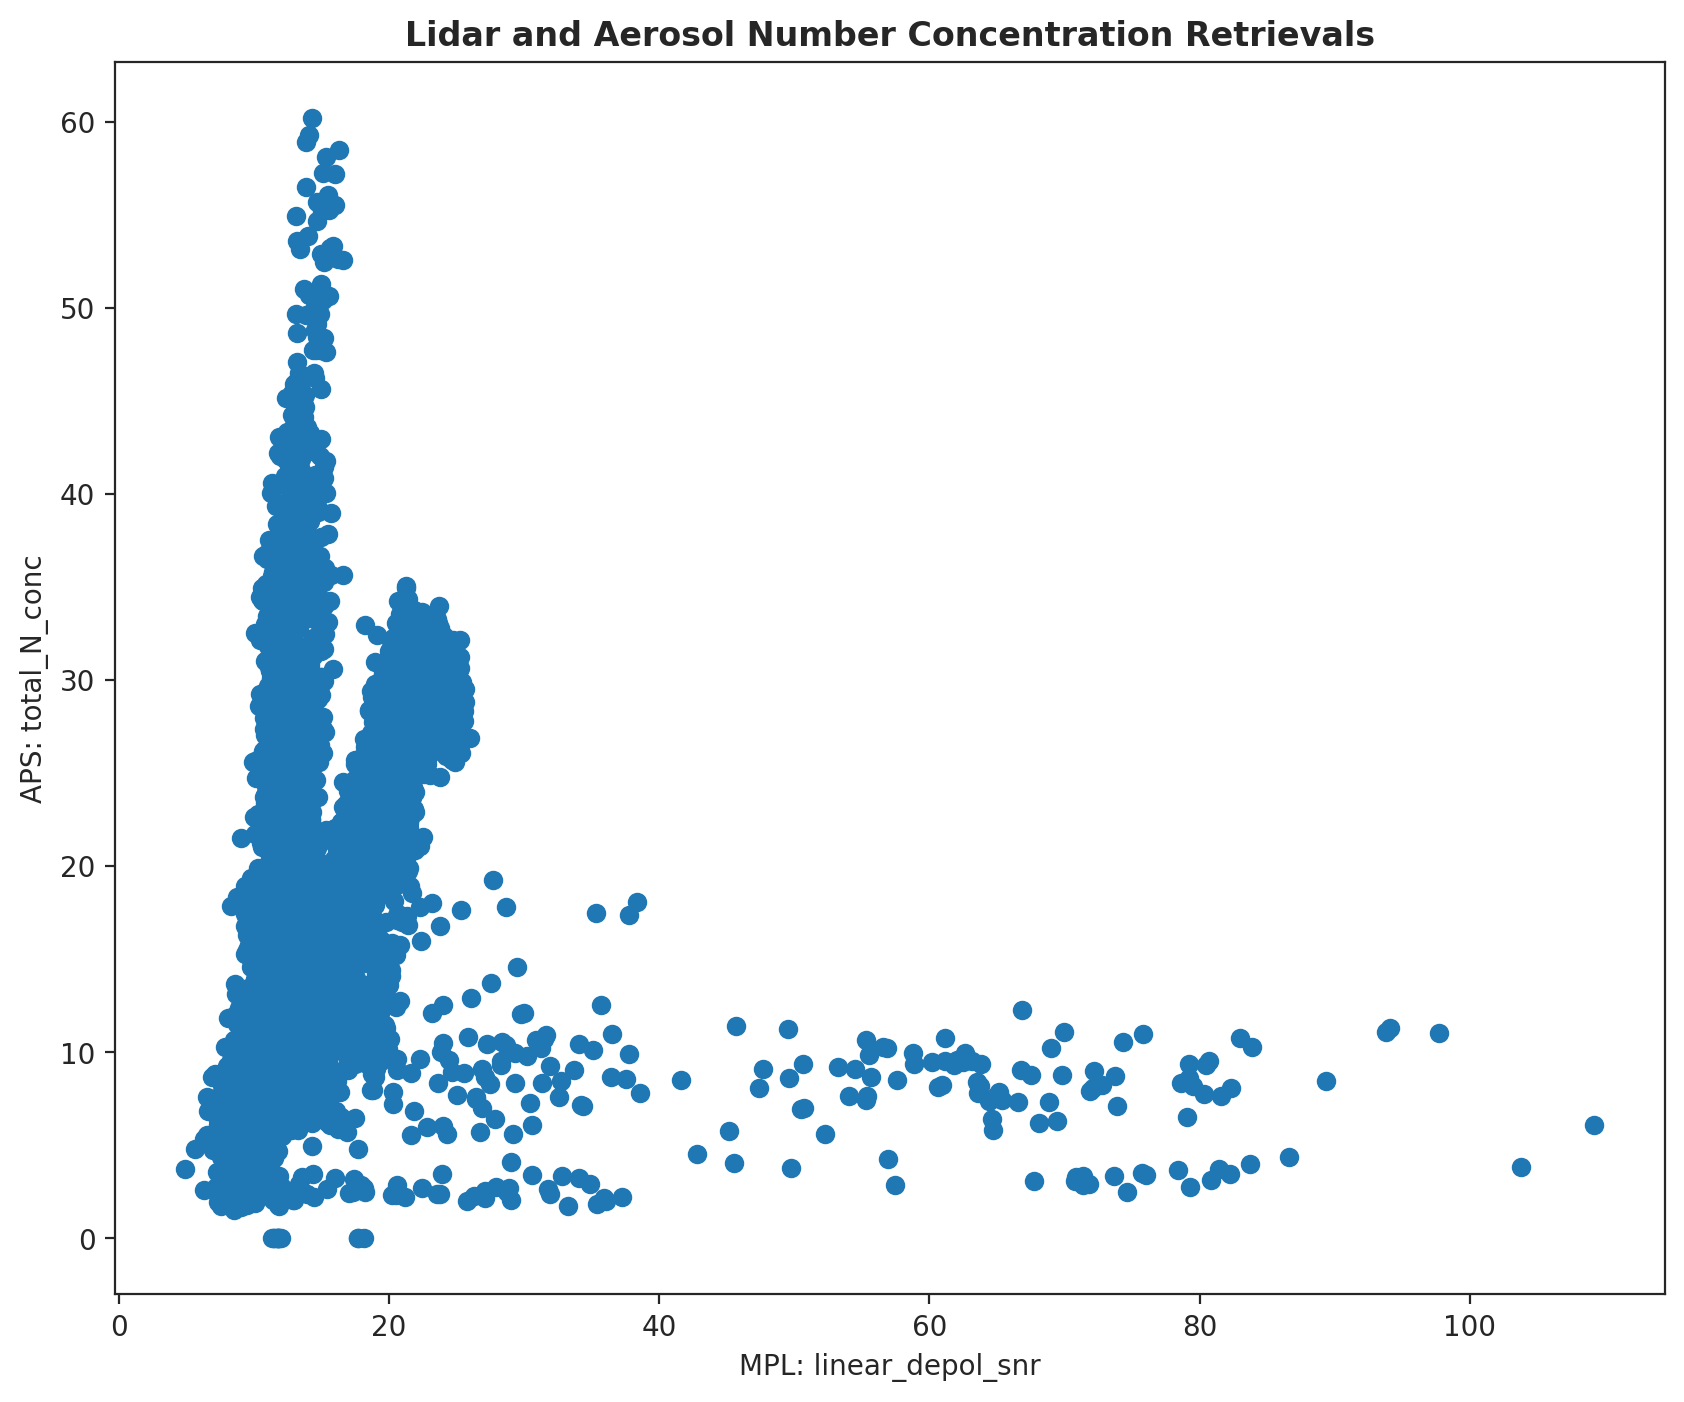

In [59]:
# Let's try a scatter plot using matplotlib
# First we need the data on the same time scale
ds_mpl2 = ds_mpl.resample(time='60s').nearest()
ds_aps2 = ds_aps.resample(time='60s').nearest()

ds = xr.merge([ds_mpl2, ds_aps2], compat='override')

# Other variables to try: backscatter_snr, linear_depol_snr, linear_depol_ratio
data = ds['linear_depol_snr'].values[:, 4]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(data, ds['total_N_conc']) # , c=ds['linear_depol_snr'].values[:, 4])
ax.set_xlabel('MPL: linear_depol_snr')
ax.set_ylabel('APS: total_N_conc')
ax.set_title('Lidar and Aerosol Number Concentration Retrievals', weight = 'bold')
plt.show()

---

### Excercises
Here are a couple additional excercises that users can work through on their own time.

#### Time series of ratios of fine particles vs. coarse particles using SMPS and APS data
Using the SMPS (ds_smps) and APS (ds_aps) data, can you calculate a ratio of fine to coarse particles?  Remember, that this data would need to be on the same timestep.

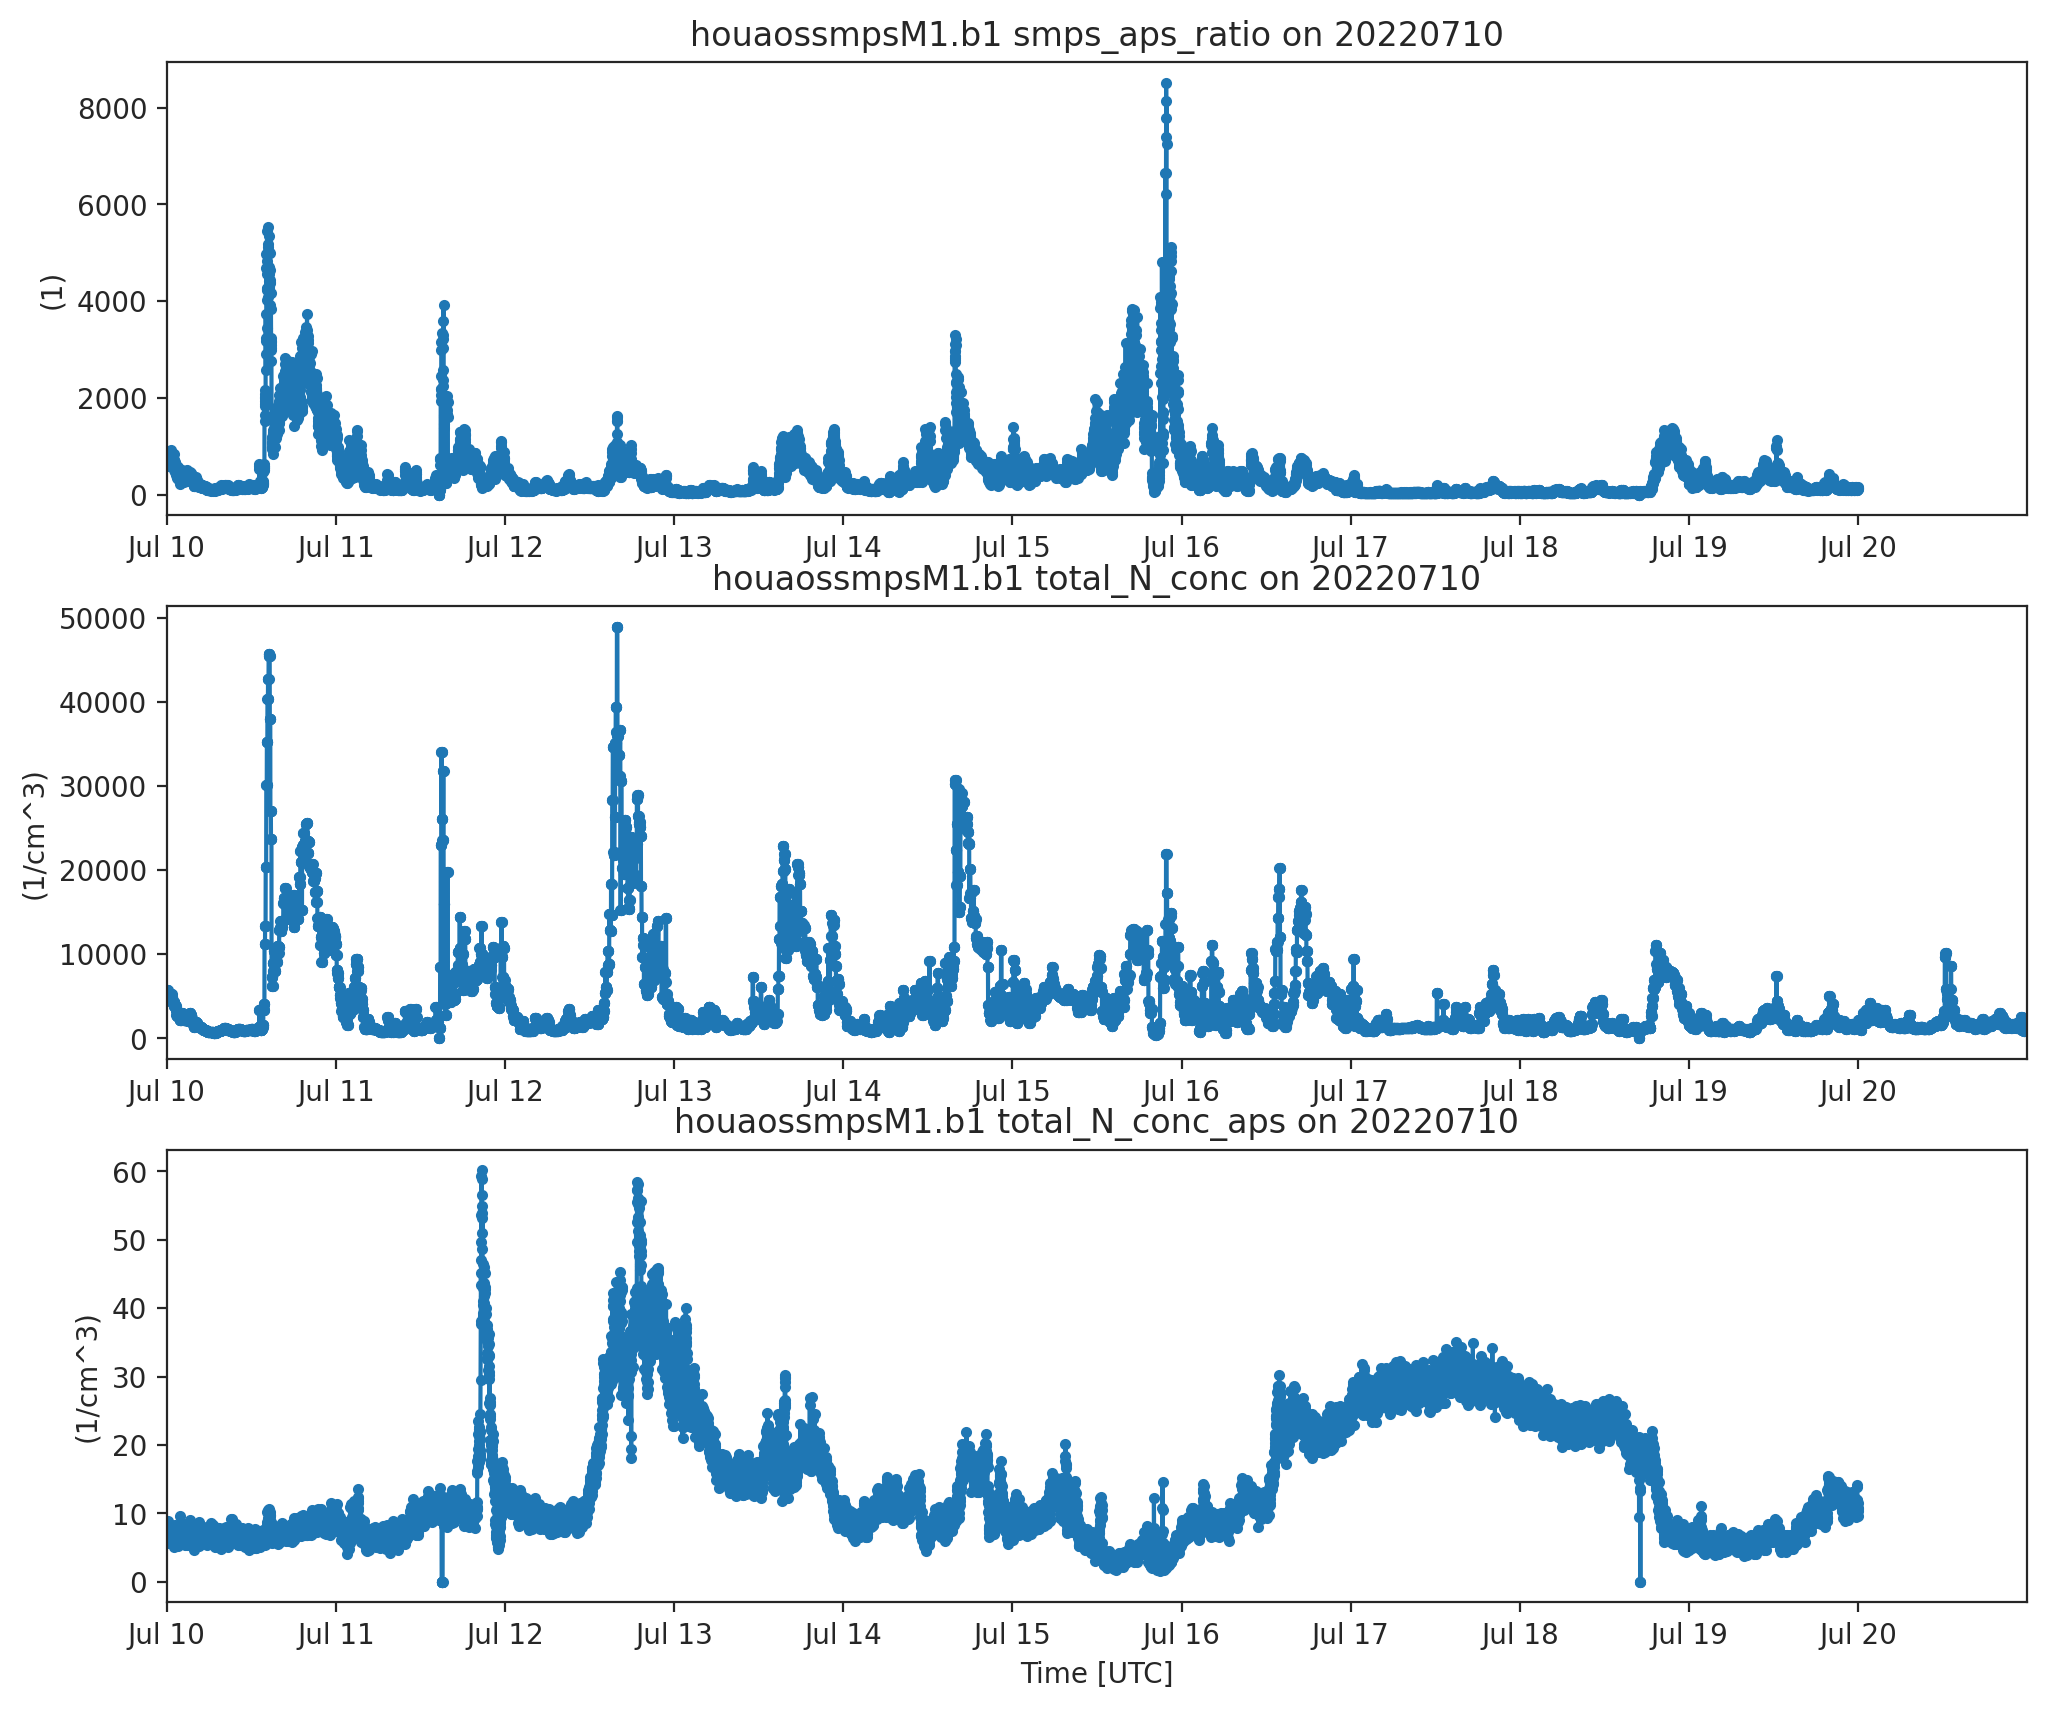

In [60]:
# First, let's resample to 1-minute averages.  Note, that this may take some time with this much data.
# The other option is to grab the nearest value
ds_smps_1m = ds_smps.resample(time='1min').nearest()
ds_aps_1m = ds_aps.resample(time='1min').nearest()

# But wait, the concentration variables have the same name!  We need to rename
ds_aps_1m = ds_aps_1m.rename_vars({'total_N_conc': 'total_N_conc_aps'})
ds_merge = xr.merge([ds_smps_1m, ds_aps_1m], compat='override')

# Next, let's calculate the ratio
ratio = ds_merge['total_N_conc'].values / ds_merge['total_N_conc_aps'].values

# Then we can add it back to the Dataset as a variable
atts = {'units': '1', 'long_name': 'Ration of SMPS to APS total_N_conc'}
da = xr.DataArray(ratio, coords=ds_merge['total_N_conc'].coords, dims=ds_merge['total_N_conc'].dims, attrs=atts)
ds_merge['smps_aps_ratio'] = da

# And then plot it wil ACT!
display = act.plotting.TimeSeriesDisplay(ds_merge, figsize=(12, 10), subplot_shape=(3,))
display.plot('smps_aps_ratio', subplot_index=(0,))
display.plot('total_N_conc', subplot_index=(1,))
display.plot('total_N_conc_aps', subplot_index=(2,))
plt.show()

#### Compare Chemical Composition Between Events

Create a pie chart of aerosol composition on July 12, 13, and compare it to that from 17-18.  This will require subsetting the ds_acsm data.

Studies have shown that Dust events can contribute to sulfate formation through the interaction of mineral dust particles with sulfur dioxide (SO2) and other atmospheric gases.

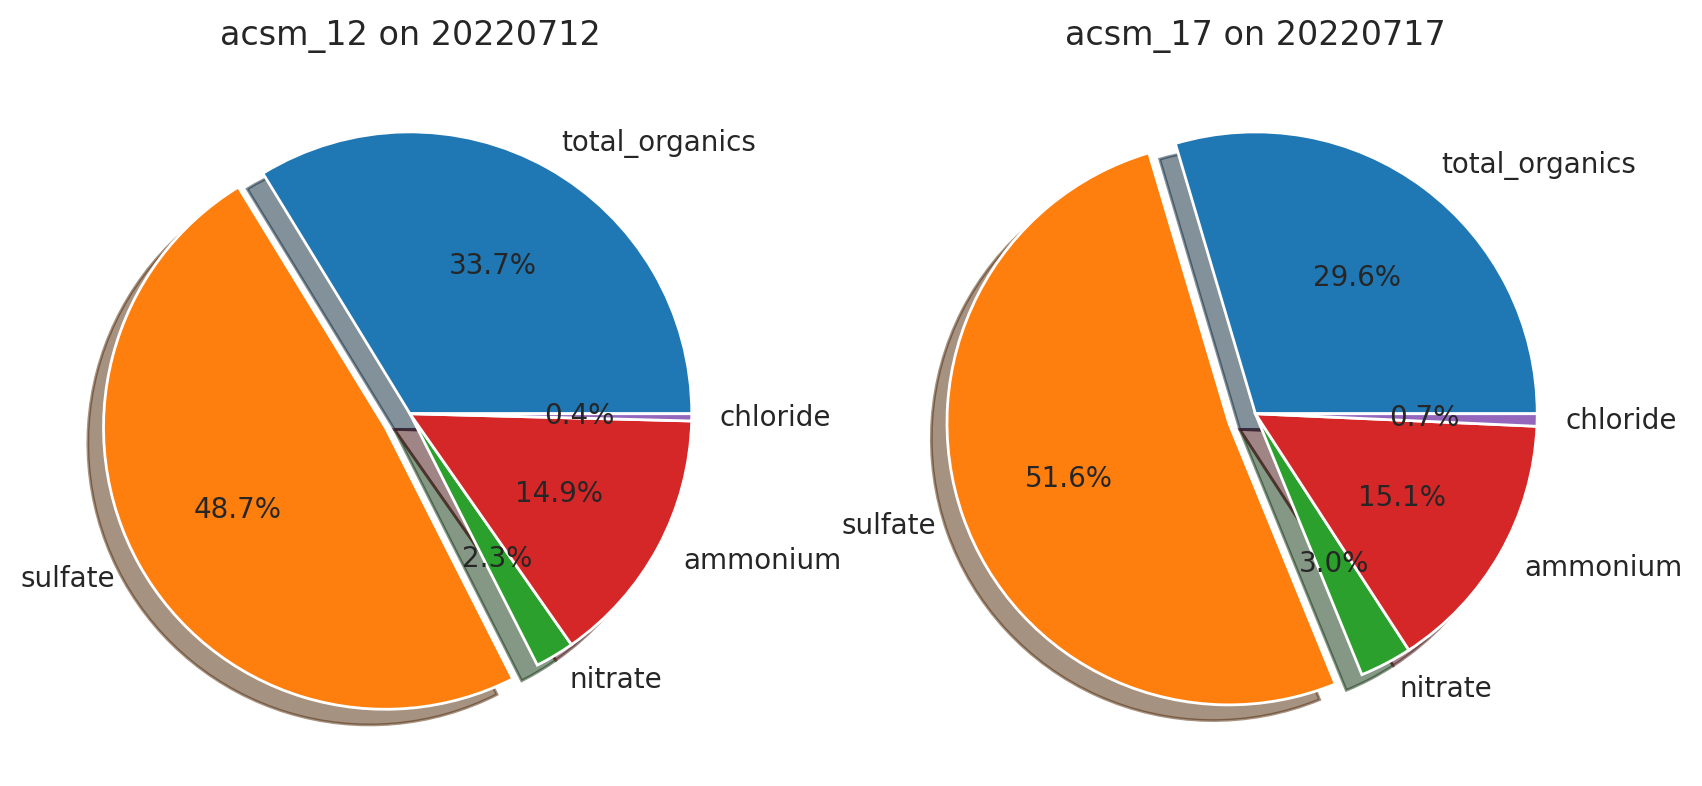

In [61]:
# First subset the data for both sets
ds_acsm_12 = ds_acsm.sel(time=slice('2022-07-12', '2022-07-13'))
ds_acsm_17 = ds_acsm.sel(time=slice('2022-07-17', '2022-07-18'))

# Run through and get data
fields = ['total_organics', 'sulfate', 'nitrate', 'ammonium', 'chloride']

# We also want to provide some keyword arguments to avoid invalid data such
# as negative values.
threshold = 0.0
fill_value = 0.0

# Create a DistributionDisplay object to compare fields
display = act.plotting.DistributionDisplay({'acsm_12': ds_acsm_12, 'acsm_17': ds_acsm_17}, 
                                           subplot_shape=(1,2), figsize=(10,14))

# We can set one of the slices to explode and give it a nice shadow.
explode = (0, 0.1, 0, 0, 0)
shadow = True

# Create a pie chart using the fields list. The percentages of the
# fields will be calculated using act.utils.calculate_percentages.
display.plot_pie_chart(
    fields,
    dsname='acsm_12',
    threshold=threshold,
    fill_value=fill_value,
    explode=explode,
    shadow=True,
    subplot_index=(0,0)
)
display.plot_pie_chart(
    fields,
    dsname='acsm_17',
    threshold=threshold,
    fill_value=fill_value,
    explode=explode,
    shadow=True,
    subplot_index=(0,1)
)
plt.show()

#### Chemical Composition Distribution

The PI charts can provide some information on the distribution but we can get more information by looking at the distribution using violin plots.  Does the dust event still show high sulfates in this view?

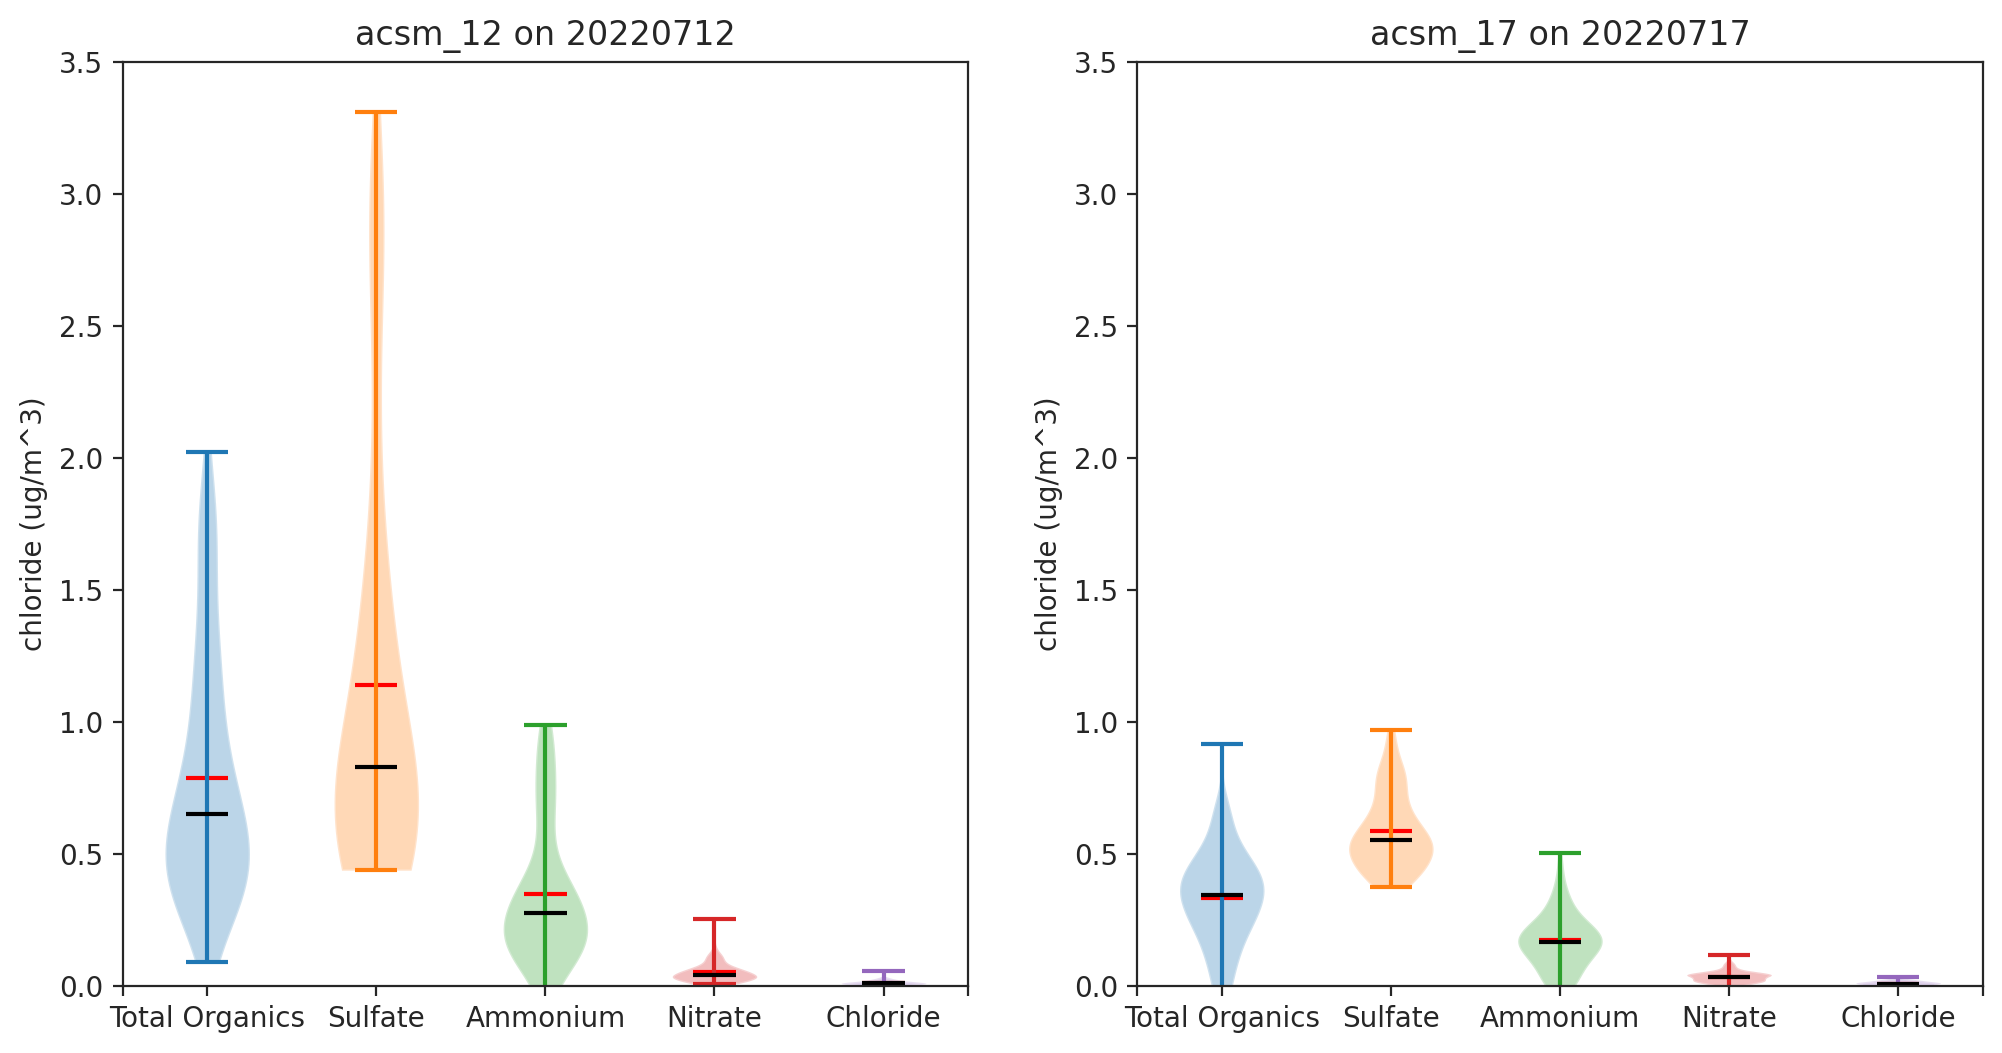

In [62]:
# Create a DistributionDisplay object to compare fields
display = act.plotting.DistributionDisplay({'acsm_12': ds_acsm_12, 'acsm_17': ds_acsm_17},
                                           subplot_shape=(1,2), figsize=(12,6))

# Compare the distributions of each composition type
display.plot_violin('total_organics', positions=[1.0], dsname='acsm_12', subplot_index=(0, 0))
display.plot_violin('sulfate', positions=[2.0], dsname='acsm_12', subplot_index=(0, 0))
display.plot_violin('ammonium', positions=[3.0], dsname='acsm_12', subplot_index=(0, 0))
display.plot_violin('nitrate', positions=[4.0], dsname='acsm_12', subplot_index=(0, 0))
display.plot_violin('chloride', positions=[5.0], dsname='acsm_12', subplot_index=(0, 0))

display.plot_violin('total_organics', positions=[1.0], dsname='acsm_17', subplot_index=(0, 1))
display.plot_violin('sulfate', positions=[2.0], dsname='acsm_17', subplot_index=(0, 1))
display.plot_violin('ammonium', positions=[3.0], dsname='acsm_17', subplot_index=(0, 1))
display.plot_violin('nitrate', positions=[4.0], dsname='acsm_17', subplot_index=(0, 1))
display.plot_violin('chloride', positions=[5.0], dsname='acsm_17', subplot_index=(0, 1))

# Update the tick information
ticks = ['', 'Total Organics', 'Sulfate', 'Ammonium', 'Nitrate', 'Chloride', '']
display.axes[0, 0].set_xticks([0.5, 1, 2, 3, 4, 5, 5.5])
display.axes[0, 1].set_xticks([0.5, 1, 2, 3, 4, 5, 5.5])
display.axes[0, 0].set_xticklabels(ticks)
display.axes[0, 1].set_xticklabels(ticks)
display.axes[0, 0].set_ylim([0, 3.5])
display.axes[0, 1].set_ylim([0, 3.5])


plt.show()

## Doppler Lidar
Out of interest, let us take a look at the doppler lidar data.

We can used both the fixed pointing mode (FPT) and plan position indicator (PPI) mode datasets to plot signal to noise ration
with an overlay of wind barbs.

In [64]:
# Download the data as before
# Read an ARM TRACER Doppler lidar FPT dataset
datastream = 'houdlfptM1.b1'
startdate = '2022-07-16T00:00:00'
enddate = '2022-07-16T23:50:00'
result_dl_fpt = glob.glob('./' + datastream +'/*')
if len(result_dl_fpt) == 0:
    result_dl_fpt = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

[DOWNLOADING] houdlfptM1.b1.20220716.110113.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.220111.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.140112.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.080113.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.010111.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.120112.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.160112.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.230111.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.060113.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.190112.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.020112.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.130113.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.170111.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.040113.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.070113.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.180112.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.050113.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.090113.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.030113.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.200112.cdf
[DOWNLOADING] houdlfptM1.b1.20220716.000

In [65]:
# Lets read all the files into one timeseries dataset.
ds_dlfpt = act.io.read_arm_netcdf(result_dl_fpt)

In [66]:
# Change intensity to signal to noise ratio
data = ds_dlfpt['intensity'].data
ds_dlfpt['intensity'].data = 1. - np.log10(data)
ds_dlfpt['intensity'].attrs['units'] = '1 - LOG10 ' + ds_dlfpt['intensity'].attrs['long_name']

In [ ]:
# Next, let's read in the ARM TRACER Doppler lidar PPI dataset
datastream = 'houdlppiM1.b1'
result_dl_ppi = glob.glob('./' + datastream +'/*')
if len(result_dl_ppi) == 0:
    result_dl_ppi = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

[DOWNLOADING] houdlppiM1.b1.20220716.160030.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.050120.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.064506.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.080030.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.104505.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.211505.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.054605.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.033006.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.043105.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.094505.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.230118.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.223105.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.191505.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.004505.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.103106.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.193006.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.054505.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.224506.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.171605.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.010118.cdf
[DOWNLOADING] houdlppiM1.b1.20220716.080

In [ ]:
# Instead of reading in all files to a dataset, lets calculate the winds for each file and
# merge them into one dataset to use for plotting the wind barbs.
multi_ds = []
for file in sorted(result_dl_ppi):
    ds = act.io.arm.read_arm_netcdf(file)
    # Calculate the winds for each houdlppi dataset.
    wind_ds = act.retrievals.compute_winds_from_ppi(
        ds, remove_all_missing=False, snr_threshold=0.008
    )
    multi_ds.append(wind_ds)

wind_ds = xr.merge(multi_ds)

In [ ]:
# Now let's create a display object containing both the houdlfpt and calculated winds dataset
display = act.plotting.TimeSeriesDisplay(
    {
        "HOU DLPPI Computed Winds Over DL FPT Backscatter": wind_ds,
        "houdlfptM1.b1": ds_dlfpt,
    },
    figsize=(20, 10),
)

# Plot the wind barbs overlayed on the signal to noise ratio
display.plot(
    'intensity', dsname='houdlfptM1.b1', cmap='NWSRef', vmax=1.0, vmin=0.0
)
display.plot_barbs_from_spd_dir(
    'wind_speed', 'wind_direction', dsname='HOU DLPPI Computed Winds Over DL FPT Backscatter', invert_y_axis=False, barbcolor='white', barb_step_y=2
)

# Update the y-limits to show plotted winds
display.axes[0].set_ylim([0, 2500])
plt.show()

### What's Happening Here?
Take a look at the [DQ Office Plots](https://plot.adc.arm.gov/PLOTS/hou/houmet/20220722/houmetM1.b1.meteogram.20220722.png) of surface meteorological variables for the day. In particular, check out the wind direction and see if that matches up with what you're seeing in the lowest level of the plots.

---

## Additional Questions for the User to Explore
1. Can you improve these matplotlib plots to make them more readable?
1. Are there other variables that you would be interested in for the data roses?
1. We looked at relationships between the MPL and APS, are there other sets of instruments that might have relationships? (SP2 and PSAP?)

#### More Advanced
1. Can we use a machine learning toolkit like scikit-learn to cluster the MPL/APS data?
1. Could we get relationships between those clusters or a classification of what it is (smoke, dust, pollution)?

---

## Next Steps
This notebook showed users how they can explore multiple different datasets using ACT.  The next steps are for the users to continue exploring and diving into the data and the questions posed at the end!

### Data Used in this Notebook
Ermold, B., & Flynn, C. Particle Soot Absorption Photometer (AOSPSAP3W1M). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1225037

Jackson, R., & Sedlacek, A. Single Particle Soot Photometer (AOSSP2BC60S). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1807910

Kuang, C., & Singh, A. Aerodynamic Particle Sizer (AOSAPS). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1407135

Kyrouac, J., & Shi, Y. Surface Meteorological Instrumentation (MET). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1786358

Muradyan, P., Cromwell, E., Koontz, A., & Coulter, R. Micropulse Lidar (MPLPOLFS). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1320657

Newsom, R., Shi, Y., & Krishnamurthy, R. Doppler Lidar (DLFPT). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1025185

Newsom, R., Shi, Y., & Krishnamurthy, R. Doppler Lidar (DLPPI). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1025186

Sivaraman, C., Flynn, D., Riihimaki, L., & Comstock, J. Cloud mask from Micropulse Lidar (30SMPLCMASK1ZWANG). Atmospheric Radiation Measurement (ARM)
User Facility. https://doi.org/10.5439/1508389

Zawadowicz, M., & Howie, J. Aerosol Chemical Speciation Monitor (AOSACSM). Atmospheric Radiation Measurement (ARM) User Facility. https://doi.org/10.5439/1762267